# Case Study: Zeeguu/API
- Backend of a web application that supports [free reading in foreign languages](https://zeeguu.org)
- Open source [repository on GH](https://github.com/zeeguu/API/)

# Everything that we did in Data Gathering

- extracting basic dependencies between python modules
- every .py file is called a module in Python
- direct relationship between file name and module name
  - file: `./zeeguu_core/model/user.py` <==>
  - module: `zeeguu_core.model.User`




In [64]:
# Installing Required Dependencies
import sys
sys.version
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
# In Collab our notebook runs in a temporary mounted file system
# Let's print the name of the folder where our script runs

import os
cwd = os.getcwd()
print(cwd)


c:\Users\eseme\Desktop\2.semester-CS\Architectural-recovery-SA


In [66]:
# Let's declare a var for the path where we're going to download a repository
# Warning: this must end in /
CODE_ROOT_FOLDER="/content/zeeguu-api/"


In [67]:
from git import Repo
# GitPython is a library that allows us to work easily with git from Python
# https://gitpython.readthedocs.io/en/stable/tutorial.html


# If the file exists, it means we've already downloaded
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu/api", CODE_ROOT_FOLDER)


In [68]:
# helper function to get a file path w/o having to always provide the /content/zeeguu-api/ prefix
def file_path(file_name):
    return CODE_ROOT_FOLDER+file_name

assert (file_path("zeeguu/core/model/user.py") == "/content/zeeguu-api/zeeguu/core/model/user.py")


In [69]:
# extracting a module name from a file name
def module_name_from_file_path(full_path):

    # e.g. ../core/model/user.py -> zeeguu.core.model.user

    file_name = full_path[len(CODE_ROOT_FOLDER):]
    file_name = file_name.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

assert 'zeeguu.core.model.user' == module_name_from_file_path(file_path('zeeguu/core/model/user.py'))

In [70]:

# naïve way of extracting imports using regular expressions
import re

# Enhanced import detection with full support for various import patterns
def import_from_line(line):
    """
    Extract imported module names from a Python import statement line.
    
    Args:
        line (str): A line of code potentially containing import statement
        
    Returns:
        list: List of imported module names or None if no imports found
    """
    # Remove any comments and trailing whitespace
    line = re.sub(r'#.*$', '', line).strip()
    
    # Skip if empty after comment removal
    if not line:
        return None
        
    # Case 1: from module import ...
    from_match = re.match(r'^from\s+(\S+)\s+import\s+(.+)$', line)
    if from_match:
        base_module = from_match.group(1)
        imported_items = from_match.group(2).split(',')
        
        # For a single import from a module, return that module
        # This maintains compatibility with the original function
        imported_item = imported_items[0].strip()
        
        # Handle 'as' alias
        if ' as ' in imported_item:
            imported_item = imported_item.split(' as ')[0].strip()
            
        # If importing specific attributes/submodules
        if imported_item != '*':
            return base_module
        
        return base_module
    
    # Case 2: import module [as alias], [module2 [as alias2]], ...
    import_match = re.match(r'^import\s+(.+)$', line)
    if import_match:
        modules = import_match.group(1).split(',')
        
        # For a single import, return that module
        # This maintains compatibility with the original function
        module = modules[0].strip()
        
        # Handle 'as' alias
        if ' as ' in module:
            module = module.split(' as ')[0].strip()
            
        return module
        
    return None

# extracts all the imported modules from a file
# returns a module of the form zeeguu_core.model.bookmark, e.g.
def imports_from_file(file):
    all_imports = []
    try:
        with open(file, encoding='utf-8') as f:
            lines = f.readlines()
    #Added the following since there are some of the files that throws a decode error and I cannot be bothered trying to salvage it, 
    # cp437 allows us to continue
    except UnicodeDecodeError:
        # Fallback to cp437 encoding if utf-8 fails
        with open(file, encoding='cp437') as f:
            lines = f.readlines()
            
    # Handle potential multi-line imports and joining them
    joined_lines = []
    current_line = ""
    
    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            # Skip empty lines and full comment lines
            if current_line:
                joined_lines.append(current_line)
                current_line = ""
            continue
            
        if current_line and (line.startswith("import ") or line.startswith("from ")):
            # This is a new import statement
            joined_lines.append(current_line)
            current_line = line
        elif current_line and (line.endswith(",") or "(" in current_line and ")" not in current_line):
            # This is a continuation of a multi-line import
            current_line += " " + line
        elif not current_line and (line.startswith("import ") or line.startswith("from ")):
            # This is the start of an import statement
            current_line = line
        elif current_line:
            # Append to current line
            current_line += " " + line
            if ")" in line and "(" in current_line:
                # End of a multi-line parenthesized import
                joined_lines.append(current_line)
                current_line = ""
                
    # Add the last line if it exists
    if current_line:
        joined_lines.append(current_line)
        
    # Process the joined lines
    for line in joined_lines:
        imp = import_from_line(line)
        if imp:
            all_imports.append(imp)
            
    return all_imports

# Example usage:
# imports_from_file(file_path('zeeguu/core/model/user.py'))
imports_from_file(file_path('zeeguu/core/model/user.py'))

['datetime',
 'json',
 'random',
 're',
 'sqlalchemy.orm',
 'zeeguu.core',
 'sqlalchemy',
 'sqlalchemy.orm',
 'sqlalchemy.orm.exc',
 'zeeguu.core.language.difficulty_estimator_factory',
 'zeeguu.core.model.language',
 'zeeguu.core.model.learning_cycle',
 'zeeguu.logging',
 'zeeguu.core.util',
 'zeeguu.core.model',
 'zeeguu.logging',
 'zeeguu.core.model.user_cohort_map',
 'zeeguu.core.model',
 'zeeguu.core.model.user_preference',
 'zeeguu.core.model',
 'zeeguu.core.model',
 'zeeguu.core.word_scheduling.basicSR.basicSR',
 'zeeguu.core.sql.queries.query_loader',
 'zeeguu.core.sql.query_building',
 'zeeguu.core.model.bookmark',
 'zeeguu.core.word_scheduling.basicSR.basicSR',
 'zeeguu.core.word_scheduling.basicSR.basicSR',
 'zeeguu.core.word_scheduling.basicSR.basicSR',
 'zeeguu.core.word_scheduling.basicSR.basicSR',
 'zeeguu.core.model.user_article',
 'dateutil.relativedelta',
 'zeeguu.core.model.user_cohort_map',
 'zeeguu.core.model',
 'zeeguu.core.model',
 'zeeguu.core.model.user_reading

In [71]:
# test
print(imports_from_file(file_path('zeeguu/core/model/bookmark.py')))
print(imports_from_file(file_path('zeeguu/core/model/unique_code.py')))

['datetime', 'sqlalchemy', 'sqlalchemy', 'sqlalchemy.orm', 'sqlalchemy.orm.exc', 'zeeguu.core.model.caption', 'zeeguu.core.model.video', 'zeeguu.logging', 'zeeguu.core.bookmark_quality.fit_for_study', 'zeeguu.core.model.article', 'zeeguu.core.model.exercise', 'zeeguu.core.model.exercise_outcome', 'zeeguu.core.model.exercise_source', 'zeeguu.core.model.language', 'zeeguu.core.model.source', 'zeeguu.core.model.text', 'zeeguu.core.model.user', 'zeeguu.core.model.user_word', 'zeeguu.core.model.learning_cycle', 'zeeguu.core.model.bookmark_user_preference', 'zeeguu.core.model.bookmark_context', 'zeeguu.core.model', 'zeeguu.core.util.encoding', 'wordstats', 'zeeguu.core.word_scheduling', 'zeeguu.core.model.context_type', 'zeeguu.core.model.article', 'zeeguu.core.model.video', 'zeeguu.core.model.article_title_context', 'zeeguu.core.model.article_fragment_context', 'zeeguu.core.model.video_title_context', 'zeeguu.core.model.video_caption_context', 'zeeguu.logging', 'zeeguu.core.tokenization', '

## Now we extract the dependencies between all the files

To do that we iterate over all the python files with the hel pf the `Path.rglob` function from `pathlib`

And we create a network with the help of the `networkx` package.

In [72]:
import pathlib
from pathlib import Path
import networkx as nx

def dependencies_graph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.Graph()

    for file in files:
        file_path = str(file)

        module_name = module_name_from_file_path(file_path)

        if module_name not in G.nodes:
            G.add_node(module_name)

        for each in imports_from_file(file_path):
            G.add_edge(module_name, each)

    return G

## Mathplotlib also has support for drawing networks

We do a simple drawing of all the files and their dependencies in our system

In [73]:
import matplotlib.pyplot as plt

# a function to draw a graph
def draw_graph(G, size, **args):
    plt.figure(figsize=size)
    nx.draw_kamada_kawai(G, **args)
    plt.show()

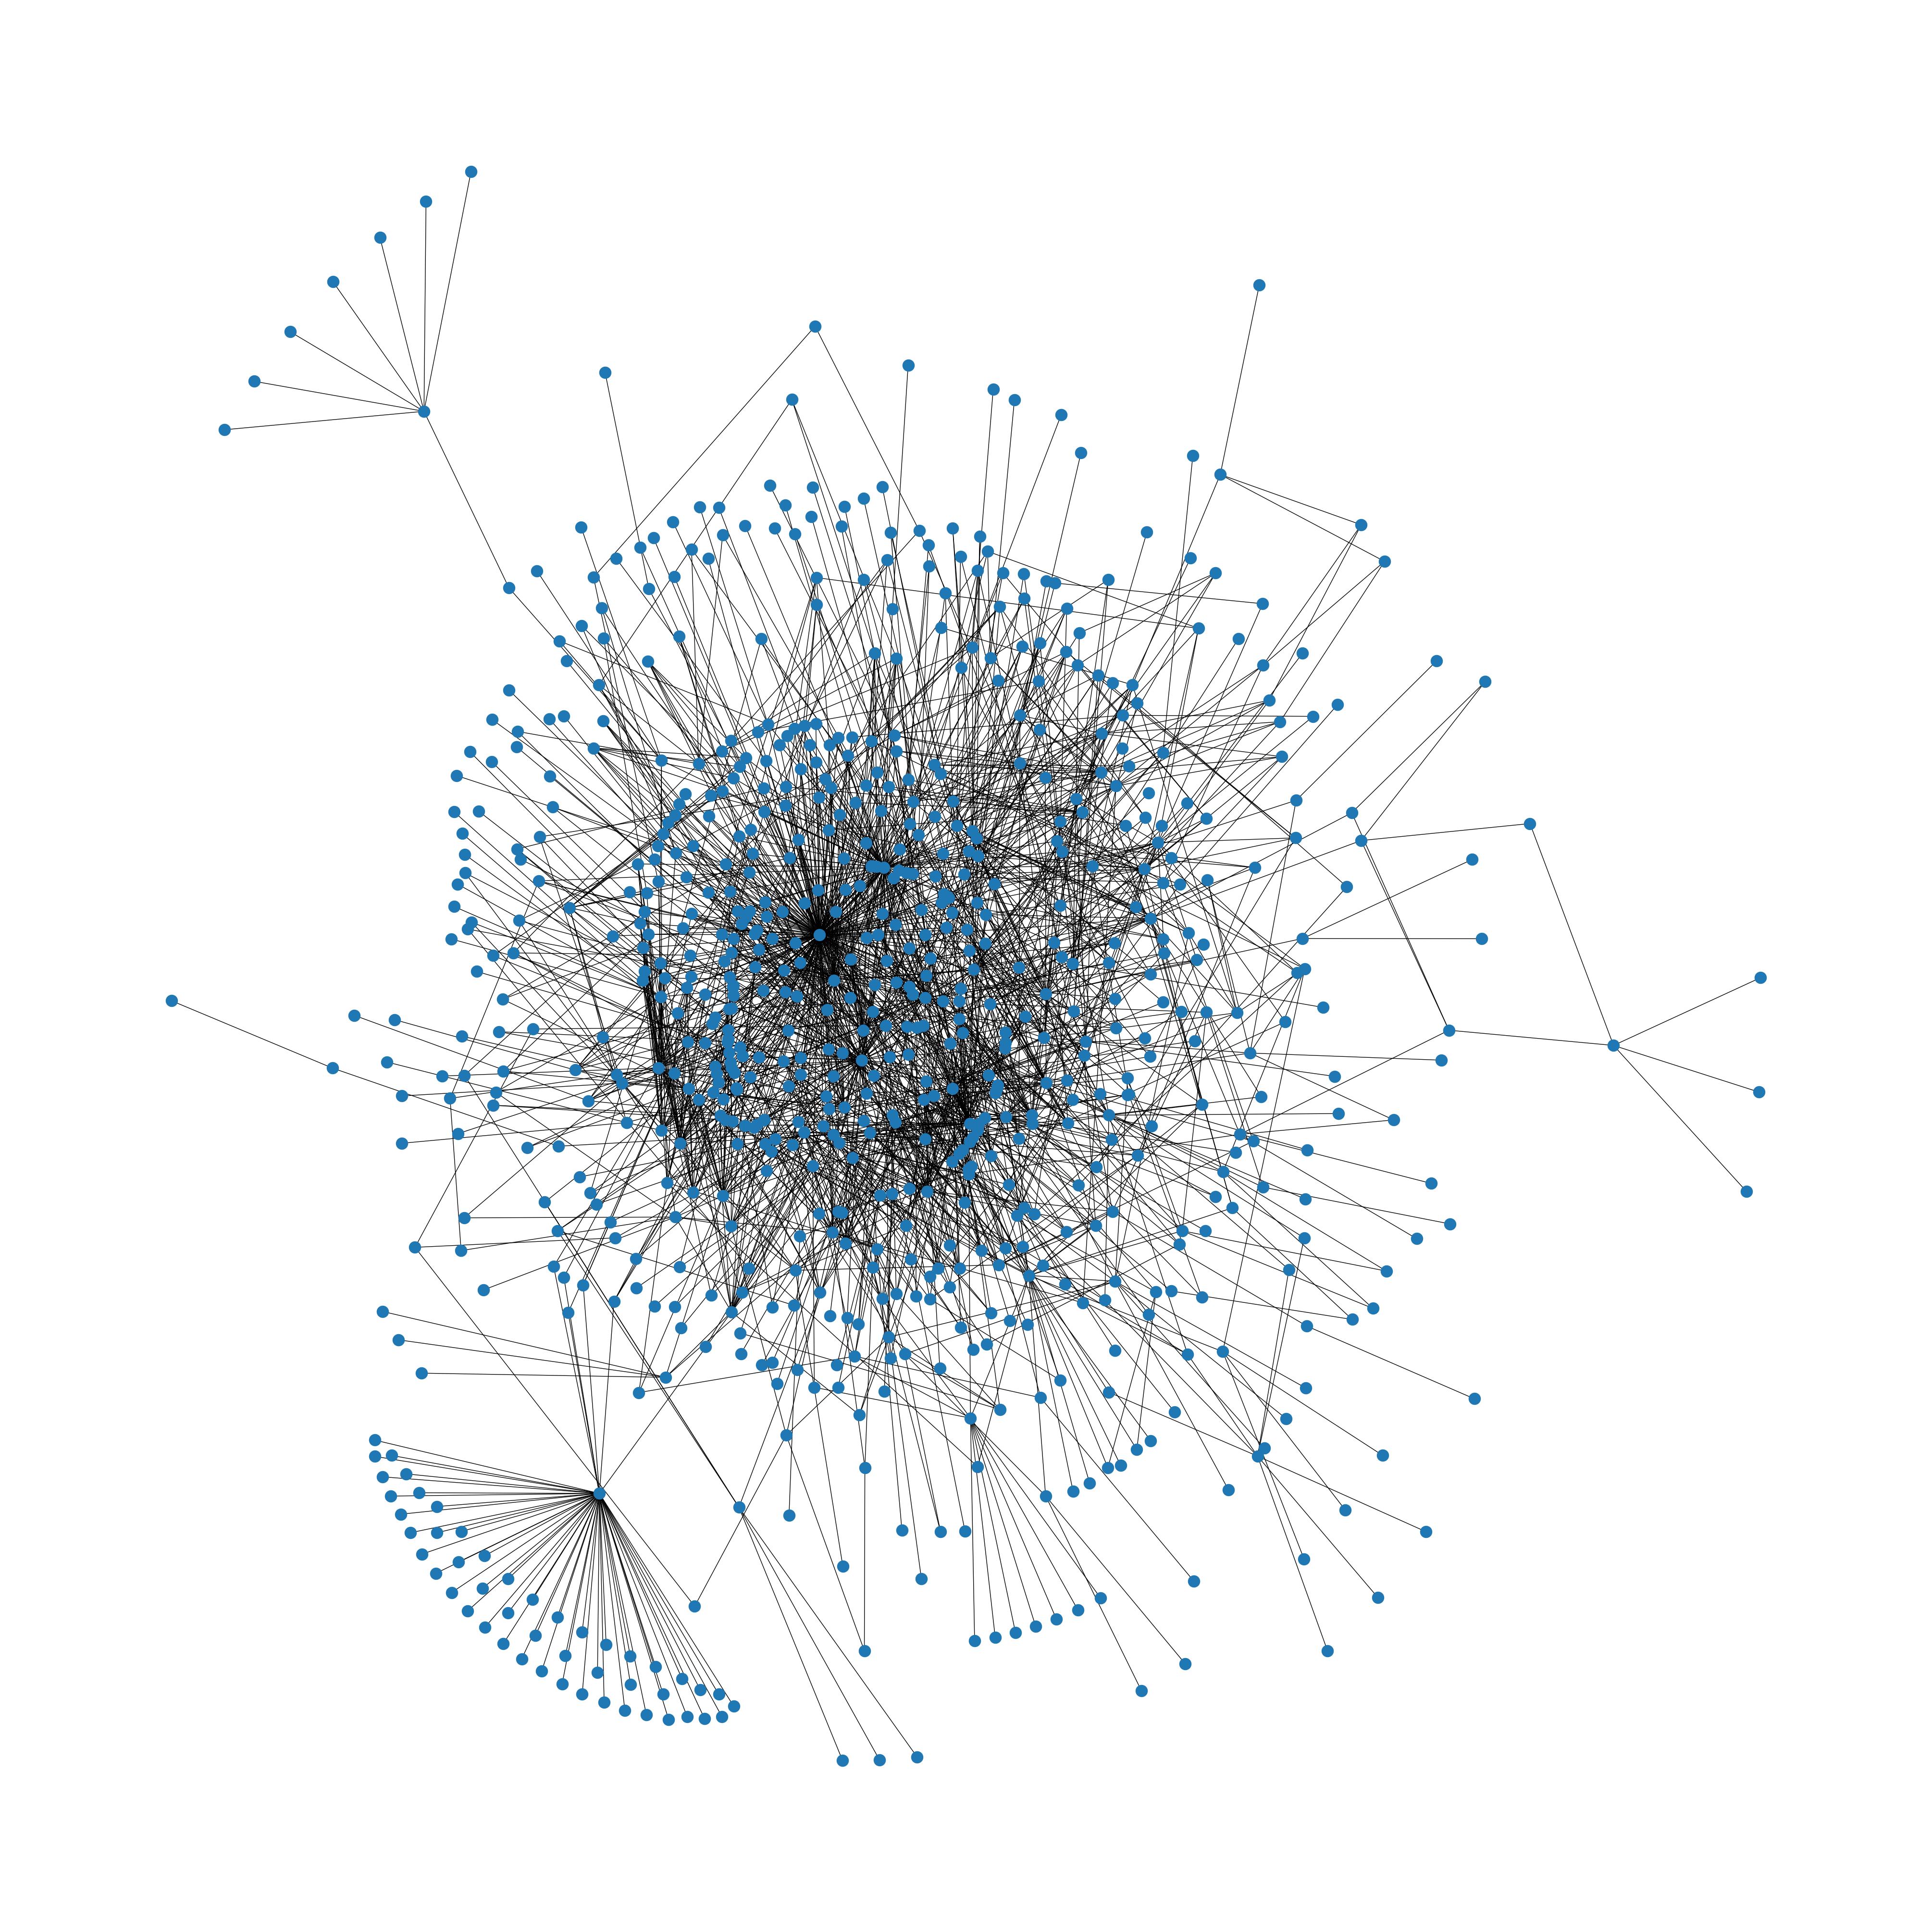

In [74]:
G = dependencies_graph(CODE_ROOT_FOLDER)
draw_graph(G, (40,40), with_labels=False)

# Abstraction

In [75]:
# Let's define some relevant modules
def relevant_module(module_name):

  if "test" in module_name:
    return False


  if module_name.startswith("zeeguu"):
    return True


  return False

In [76]:
# However, if we think a bit more about it, we realize that a dependency graph
# is a directed graph (e.g. module A depends on m)
# with any kinds of graph either directed (nx.DiGraph) or
# non-directed (nx.Graph)

def dependencies_digraph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        file_path = str(file)

        source_module = module_name_from_file_path(file_path)
        if not relevant_module(source_module):
          continue

        if source_module not in G.nodes:
            G.add_node(source_module)

        for target_module in imports_from_file(file_path):

            if relevant_module(target_module):
              G.add_edge(source_module, target_module)


    return G


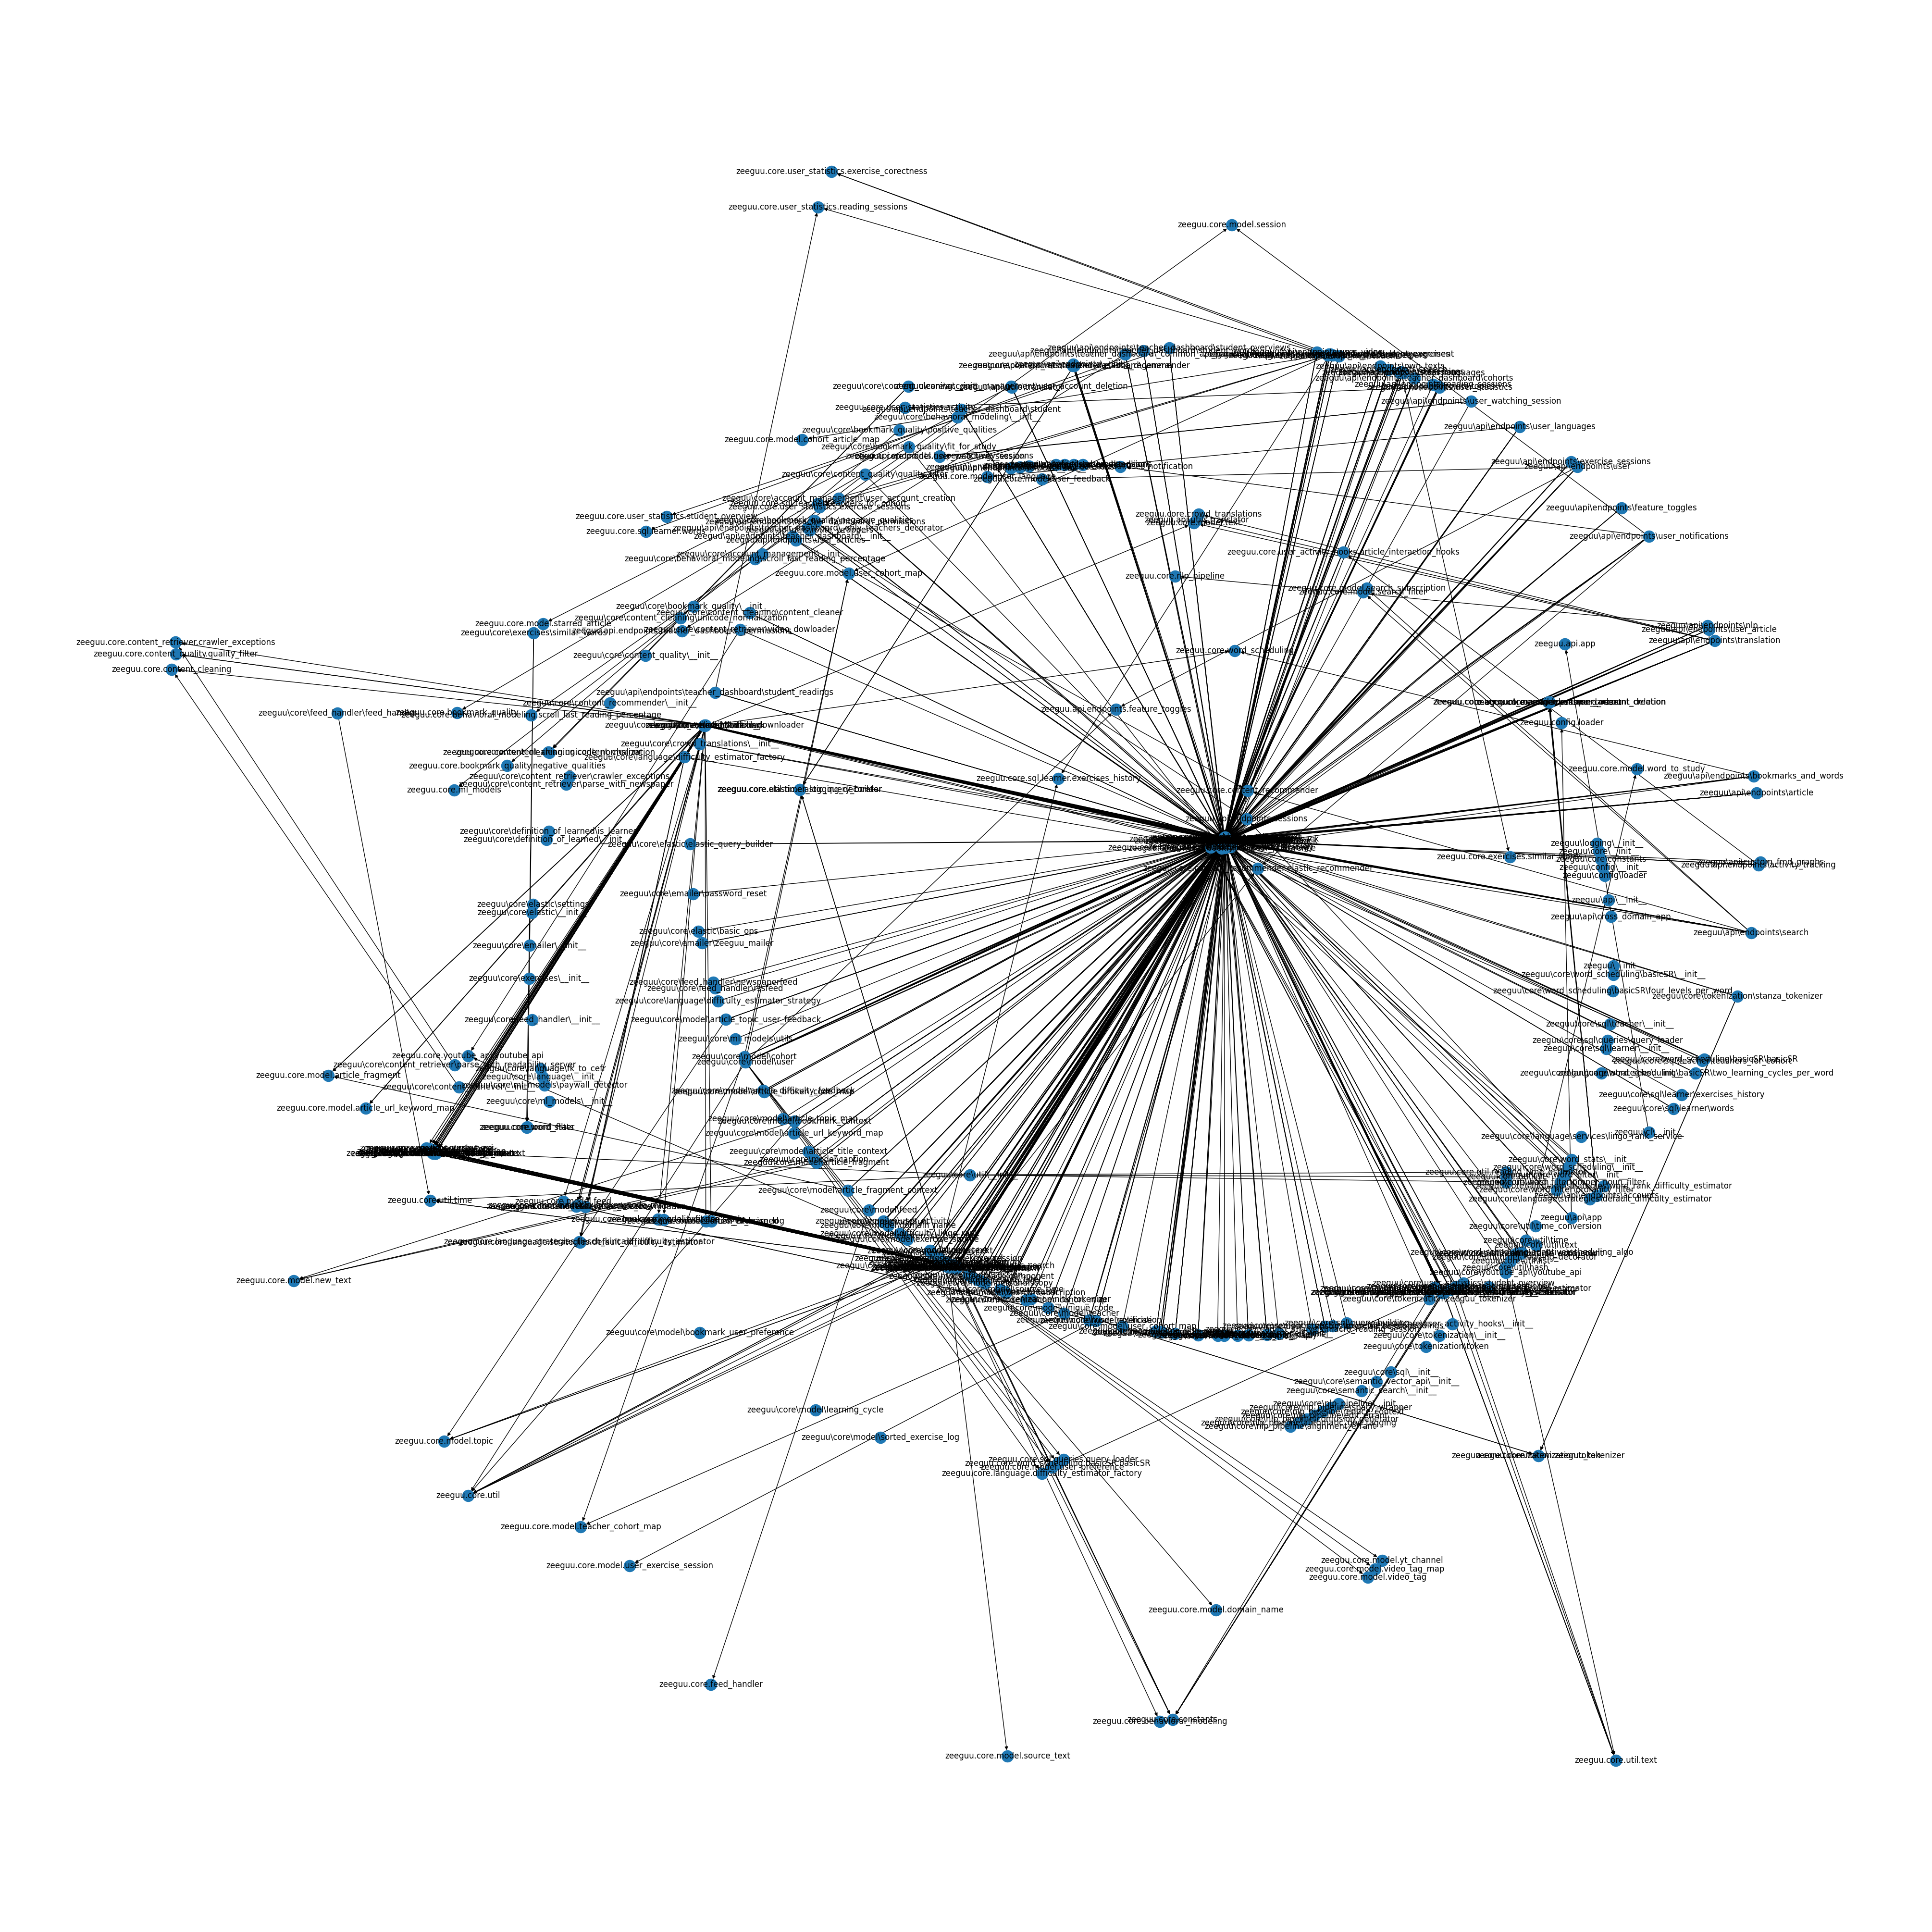

In [77]:
# Looking at the directed graph
DG = dependencies_digraph(CODE_ROOT_FOLDER)
draw_graph(DG, (40,40), with_labels=True)

# Basic Abstraction Using Hierarchical Module Structure & Naming Conventions

- abstracting the imports between the modules along the module hierarchy
- also taking into account naming conventions to filter out external modules

In [78]:
# extracts the parent of depth X
def top_level_package(module_name, depth=1):
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_package("zeeguu.core.model.util", 1) == "zeeguu")
assert (top_level_package("zeeguu.core.model.util", 2) == "zeeguu.core")

In [79]:
def abstracted_to_top_level(G, depth=1):
    aG = nx.DiGraph()
    for each in G.edges():
        src = top_level_package(each[0], depth)
        dst = top_level_package(each[1], depth)

        if src != dst:
          aG.add_edge(src, dst)

    return aG

In [80]:
ADG = abstracted_to_top_level(DG, 3)

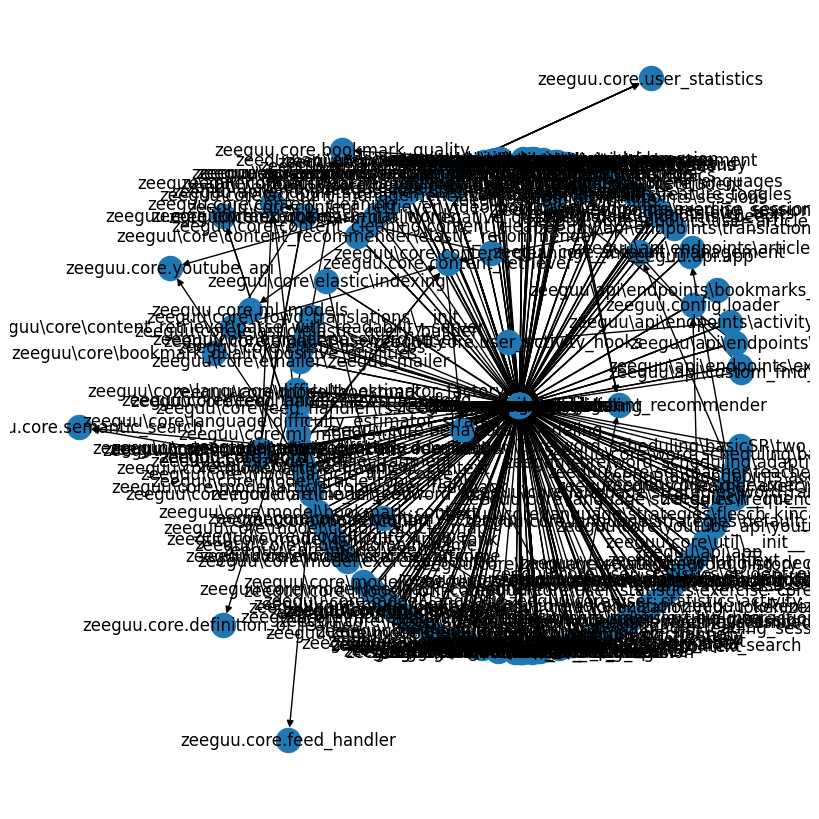

In [81]:
draw_graph(ADG, (8,8), with_labels=True)